# Key Insights

In [ ]:
import pandas as pd
import yaml

results = pd.read_csv(open("../results/benchmark_results.csv"))
meta = yaml.safe_load(open("../results/metadata.yaml"))

results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]

## Relative runtime bar plots

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from humanize import naturaldelta
from matplotlib.patches import Patch

In [2]:
max_num_solvers = 5  # TODO


def plot_runtime_slowdowns(df, figsize=(12, 6)):
    """Plots relative runtimes (slowdown factors) in a bar chart.

    Expects df to have columns: Benchmark, Solver, Runtime (s), Status, Timeout
    """
    if "bench-size" in df.columns:
        df["Benchmark"] = df["bench-size"]
    # Fill NaN runtimes and non-ok statuses with TO value
    df.loc[df["Runtime (s)"].isna(), "Runtime (s)"] = df["Timeout"]
    df.loc[df.query('Status != "ok"').index, "Runtime (s)"] = df["Timeout"]

    # Find the fastest solver for each benchmark
    df_ok = df.query('Status == "ok"')
    fastest_runtimes = df_ok.loc[df_ok.groupby("Benchmark")["Runtime (s)"].idxmin()]

    # Sort benchmarks by fastest runtime
    sorted_benchmarks = fastest_runtimes.sort_values("Runtime (s)").reset_index(
        drop=True
    )

    # Normalize runtimes to find each solver's slowdown factor
    df = df.merge(
        fastest_runtimes[["Benchmark", "Runtime (s)"]],
        on="Benchmark",
        suffixes=("", "_fastest"),
    )
    df["Slowdown"] = df["Runtime (s)"] / df["Runtime (s)_fastest"]
    max_slowdown = max(df.query('Status == "ok"')["Slowdown"])
    df.loc[df.query('Status != "ok"').index, "Slowdown"] = 1.1 * max_slowdown

    # Color map
    color_map = {
        "cbc": "#F9CD5A",  # yellow
        "glpk": "#7C3AED",  # purple
        "gurobi": "#F66C49",  # red
        "highs": "#43BF94",  # green
        "scip": "#3B82F6",  # blue
    }  # TODO change these colors on the website too!
    width = 1 / (max_num_solvers + 1)  # the width of the bars

    fig, ax = plt.subplots(figsize=figsize, layout="constrained")

    # Add a dotted line at y=1
    ax.axhline(1, color="grey", linestyle="--")

    # Plot each benchmark
    for i, benchmark in enumerate(sorted_benchmarks["Benchmark"]):
        benchmark_data = df[df["Benchmark"] == benchmark].sort_values(
            "Slowdown", ascending=False
        )
        num_solvers = len(benchmark_data)
        # Compute x-axis offsets
        xs = i + (np.arange(num_solvers) * width) - 0.5 + width
        # Pick colors based on solvers
        colors = [color_map[s] for s in benchmark_data["Solver"]]
        ax.bar(xs, benchmark_data["Slowdown"], width, color=colors)
        # Add text labels on top of bars
        for i, x in enumerate(xs):
            if benchmark_data.iloc[i]["Status"] == "ok":
                label = f"{benchmark_data.iloc[i]['Slowdown']:.1f}x"
                kwargs = {}
            else:
                label = benchmark_data.iloc[i]["Status"]
                kwargs = {"color": "red", "weight": "bold"}
            ax.text(
                x,
                benchmark_data.iloc[i]["Slowdown"] + 0.5,
                label,
                ha="center",
                **kwargs,
            )

    # Set x-ticks and labels
    xlabels = [
        f"{r['Benchmark']}\nFastest solver: {naturaldelta(r['Runtime (s)'])}"
        for _, r in sorted_benchmarks.iterrows()
    ]
    ax.set_xticks(np.arange(len(sorted_benchmarks)), xlabels)

    # Add labels and title
    ax.set_ylabel("Relative Runtime (normalized)")
    ax.set_title("Solver Runtime Comparison")
    ax.legend(
        handles=[Patch(color=c, label=s) for s, c in color_map.items()],
        title="Solver",
        loc="upper right",
    )


# TODO for overall plot -- num solved inside bar?
# TODO make non-ok bars more transparent?

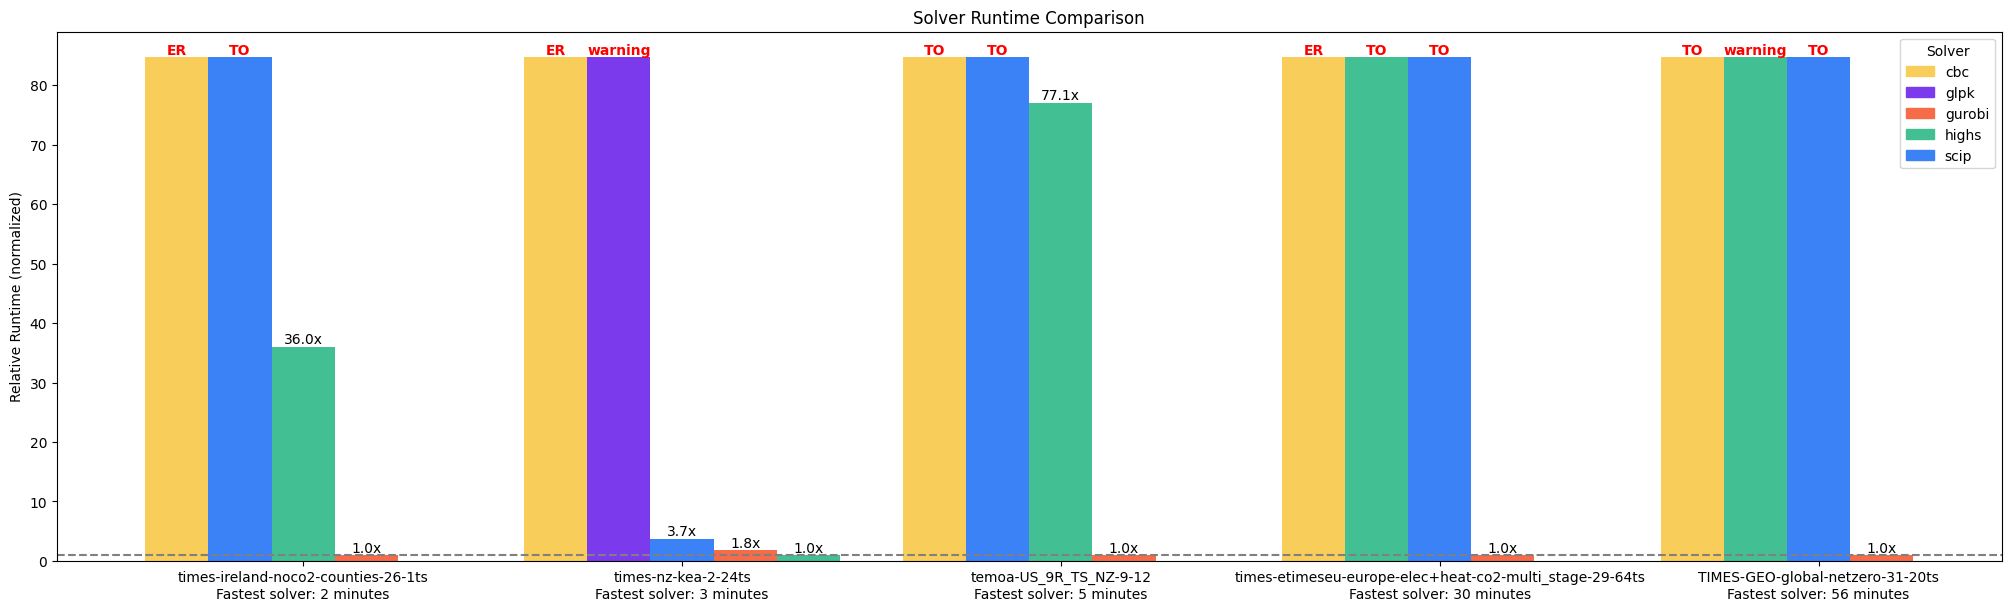

In [5]:
times_problems = [
    "times-etimeseu-france-elec+heat-co2-multi_stage",
    "TIMES-GEO-global-netzero",
    "times-etimeseu-france-elec+heat-multi_stage",
    "times-etimeseu-france-elec+heat-co2-single_stage",
    "times-ireland-noco2",
    "times-etimeseu-europe-elec+heat-multi_stage",
    "times-etimeseu-europe-elec+heat-co2-multi_stage",
    "times-etimeseu-europe-elec+heat-co2-single_stage",
    "TIMES-GEO-global-base",
    "times-nz-tui",
    "times-etimeseu-france-elec+heat-single_stage",
    "times-ireland-noco2-counties",
    "times-etimeseu-europe-elec+heat-single_stage",
    "times-nz-kea",
]
times_to_plot = {
    "TIMES-GEO-global-netzero",
    "times-etimeseu-europe-elec+heat-co2-multi_stage",
    "times-nz-kea",
    "times-ireland-noco2-counties",
    "temoa-US_9R_TS_NZ",
}
times_results = results[results["Benchmark"].isin(times_to_plot)]

# Fix size names
times_results.loc[
    times_results.query('`bench-size` == "times-ireland-noco2-counties-26-1h"').index,
    "bench-size",
] = "times-ireland-noco2-counties-26-1ts"
times_results.loc[
    times_results.query('`bench-size` == "times-nz-kea-2-24h"').index, "bench-size"
] = "times-nz-kea-2-24ts"

# Remove old solver versions
times_results = times_results.sort_values(
    ["bench-size", "Solver", "Solver Release Year"]
).drop_duplicates(["bench-size", "Solver"], keep="last")

plot_runtime_slowdowns(times_results, figsize=(20, 6))

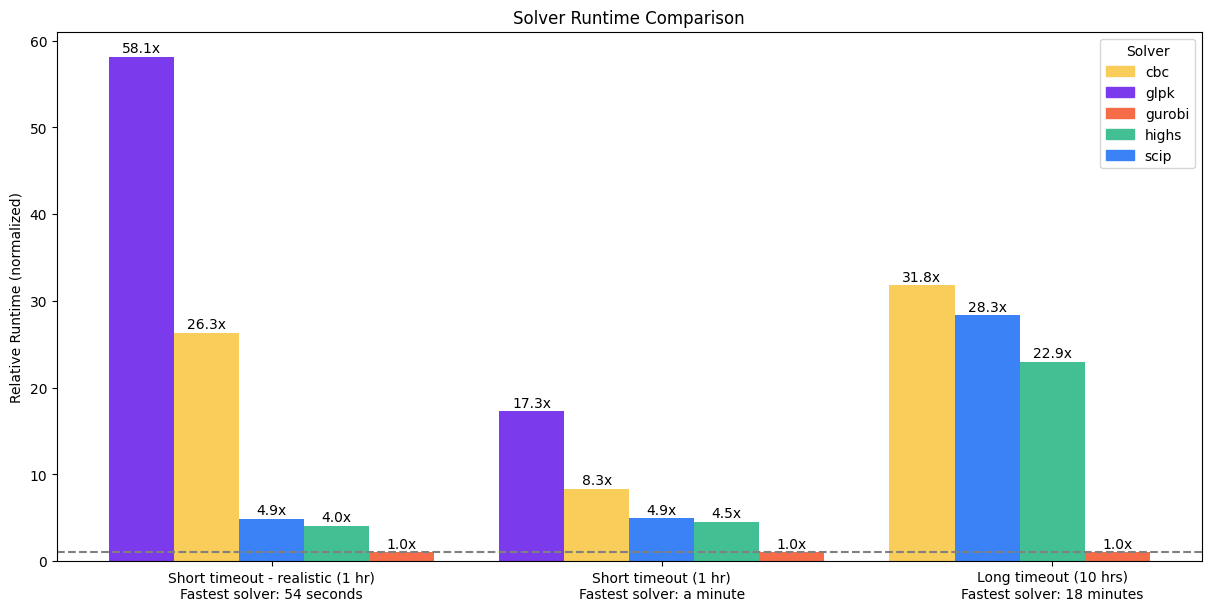

In [ ]:
from io import StringIO

# SGM results
data = """Benchmark,Solver,Runtime (s),Status,Timeout
Short timeout (1 hr),gurobi,92.01,ok
Short timeout (1 hr),highs,416.31,ok
Short timeout (1 hr),scip,453.96,ok
Short timeout (1 hr),cbc,765.87,ok
Short timeout (1 hr),glpk,1588.5,ok
Short timeout - realistic (1 hr),gurobi,54.86,ok
Short timeout - realistic (1 hr),highs,220.96,ok
Short timeout - realistic (1 hr),scip,267.89,ok
Short timeout - realistic (1 hr),cbc,1445.51,ok
Short timeout - realistic (1 hr),glpk,3189.2,ok
Long timeout (10 hrs),gurobi,1124.64,ok
Long timeout (10 hrs),highs,25793.13,ok
Long timeout (10 hrs),scip,31847.48,ok
Long timeout (10 hrs),cbc,35747.02,ok
"""
df = pd.read_csv(StringIO(data))

# TODO add num solved as fraction

plot_runtime_slowdowns(df, figsize=(12, 6))

### What's feasible for open source solvers?

In [26]:
import humanize

# First get the fastest OS solver for each bench-size
os_feasible_results = (
    results.query("Solver != 'gurobi' and Status == 'ok'")
    .sort_values("Runtime (s)")
    .drop_duplicates(["bench-size"])
)

# Make a table of metadata
meta_data = []
for n, b in meta["benchmarks"].items():
    for s in b["Sizes"]:
        bench_size = n + "-" + s["Name"]
        meta_data.append(
            (
                bench_size,
                b["Problem class"],
                b["Modelling framework"],
                s["Num. variables"],
                s["Num. constraints"],
                s["Spatial resolution"],
                s["Temporal resolution"],
            )
        )
metadata_df = pd.DataFrame(
    meta_data,
    columns=[
        "bench-size",
        "Problem Class",
        "Modelling Framework",
        "Num. Variables",
        "Num. Constraints",
        "Spatial Resolution",
        "Temporal Resolution",
    ],
)

# Merge to get a table with bench-size, fastest os solver, runtime, num vars, num constraints, temp/spatial resolutions
os_feasible_results = os_feasible_results.join(
    metadata_df.set_index("bench-size"), on="bench-size"
)
os_feasible_results["Runtime"] = os_feasible_results["Runtime (s)"].apply(
    humanize.naturaldelta
)
cols_of_interest = [
    "Benchmark",
    "Size",
    "Num. Variables",
    "Num. Constraints",
    "Spatial Resolution",
    "Temporal Resolution",
    "Solver",
    "Solver Version",
    "Runtime",
]

# The largest LP problems solveable by open solvers
os_feasible_results.query('`Problem Class` == "LP"').sort_values(
    "Num. Variables", ascending=False
).head()[cols_of_interest]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime
792,temoa-US_9R_TS_NZ,9-12,1801794,1594085,9 nodes,"12 time slices (4 seasons, 3 times of day)",highs,1.10.0,7 hours
499,temoa-US_9R_TS_SP,9-12,1801794,1594116,9 nodes,"12 time slices (4 seasons, 3 times of day)",highs,1.10.0,5 hours
1072,temoa-US_9R_TS,9-12,1801794,1594079,9 nodes,"12 time slices (4 seasons, 3 times of day)",highs,1.10.0,3 hours
1016,times-ireland-noco2-counties,26-1h,1235884,873805,26 (Transport) / 1 (all other sectors),1,highs,1.10.0,an hour
1277,temoa-US_9R_TS_NZ_trunc_4periods,9-12,708899,665474,9 nodes,"12 time slices (4 seasons, 3 times of day)",highs,1.9.0,47 minutes


In [27]:
# The largest MILP problems solveable by open solvers
os_feasible_results.query('`Problem Class` == "MILP"').sort_values(
    "Num. Variables", ascending=False
).head()[cols_of_interest]

,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime
1013,tulipa-1_EU_investment_simple,28-1h,1619451,2429440,28,1,scip,9.2.2,an hour
694,genx-10_IEEE_9_bus_DC_OPF,9-1h,639483,1235166,9,1,scip,9.2.2,5 minutes
1372,tulipa-1_EU_investment_simple,28-4.3h,372935,559104,28,4.3,scip,9.2.2,2 minutes
1264,pypsa-eur-elec-op-ucconv,2-3h,186880,385478,2,3,scip,9.2.2,12 minutes
419,genx-2_three_zones_w_electrolyzer,3-1h,177437,232867,3,1,cbc,2.10.12,16 minutes


In [30]:
# The largest LP problems solveable by open solvers for each model framework
longest_bench_per_model = (
    os_feasible_results.query('`Problem Class` == "LP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
)
longest_bench_per_model.sort_values("Num. Variables", ascending=False)[
    ["Modelling Framework"] + cols_of_interest
]

,Modelling Framework,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime
792,TEMOA,temoa-US_9R_TS_NZ,9-12,1801794,1594085,9 nodes,"12 time slices (4 seasons, 3 times of day)",highs,1.10.0,7 hours
1016,TIMES,times-ireland-noco2-counties,26-1h,1235884,873805,26 (Transport) / 1 (all other sectors),1,highs,1.10.0,an hour
1184,PyPSA,pypsa-eur-elec-op,2-1h,455458,928600,2,1,cbc,2.10.11,2 minutes
589,GenX,genx-8_three_zones_w_colocated_VRE_storage_ele...,3-1h,257129,302449,3,168,cbc,2.10.12,47 minutes
725,DCOPF,DCOPF-Carolinas_2M,1-997,122017,199255,997 nodes,1,highs,1.9.0,9 seconds


In [31]:
# The largest MILP problems solveable by open solvers for each model framework
longest_bench_per_model = (
    os_feasible_results.query('`Problem Class` == "MILP"')
    .sort_values("Num. Variables", ascending=False)
    .drop_duplicates("Modelling Framework")
)
longest_bench_per_model.sort_values("Num. Variables", ascending=False)[
    ["Modelling Framework"] + cols_of_interest
]

,Modelling Framework,Benchmark,Size,Num. Variables,Num. Constraints,Spatial Resolution,Temporal Resolution,Solver,Solver Version,Runtime
1013,Tulipa,tulipa-1_EU_investment_simple,28-1h,1619451,2429440,28,1,scip,9.2.2,an hour
694,GenX,genx-10_IEEE_9_bus_DC_OPF,9-1h,639483,1235166,9,1,scip,9.2.2,5 minutes
1264,PyPSA,pypsa-eur-elec-op-ucconv,2-3h,186880,385478,2,3,scip,9.2.2,12 minutes
731,DCOPF,DCOPF-Carolinas_uc_1W,1-997,131278,220143,997 nodes,1,scip,9.2.2,39 minutes
912,PowerModels,Sienna_modified_RTS_GMLC_DA_sys_NetDC_Horizon2...,1-1h,19392,25080,1,1,scip,8.0.3,16 minutes
524,Sienna,Sienna_modified_RTS_GMLC_DA_sys_NetCopperPlate...,1-1h,7380,6048,1,1,scip,9.2.2,53 seconds
